In [58]:
%pip install opencv-python scikit-image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, auc, roc_auc_score)
from skimage.feature import hog, local_binary_pattern
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [60]:
def load_dataset(dataset_path, img_size=(128, 128)):
    dataset_path = Path(dataset_path)
    images = []
    labels = []
    class_names = []

    for class_folder in sorted(dataset_path.iterdir()):
        if class_folder.is_dir():
            class_name = class_folder.name
            class_names.append(class_name)
            print(f"Loading class: {class_name}")

            count = 0
            for img_path in class_folder.glob("*.png"):
                img = cv2.imread(str(img_path))
                if img is not None:
                    img_resized = cv2.resize(img, img_size)
                    images.append(img_resized)
                    labels.append(class_name)
                    count += 1
            print(f"  → Loaded {count} images")

    print(f"\nTotal images loaded: {len(images)}")
    print(f"Classes: {class_names}")
    print(f"Class distribution:")
    for class_name in class_names:
        count = labels.count(class_name)
        print(f"  - {class_name}: {count} images")

    return np.array(images), np.array(labels), class_names

In [61]:
DATASET_PATH = r"C:\Users\LENOVO\OneDrive\Documents\KULLYEAH\Semester 3\Artificial Intelligence\Project KA\Brain_Stroke_CT_Dataset"
images, labels, class_names = load_dataset(DATASET_PATH)

Loading class: Bleeding
  → Loaded 1093 images
Loading class: Ischemia
  → Loaded 1130 images
Loading class: Normal
  → Loaded 4427 images

Total images loaded: 6650
Classes: ['Bleeding', 'Ischemia', 'Normal']
Class distribution:
  - Bleeding: 1093 images
  - Ischemia: 1130 images
  - Normal: 4427 images


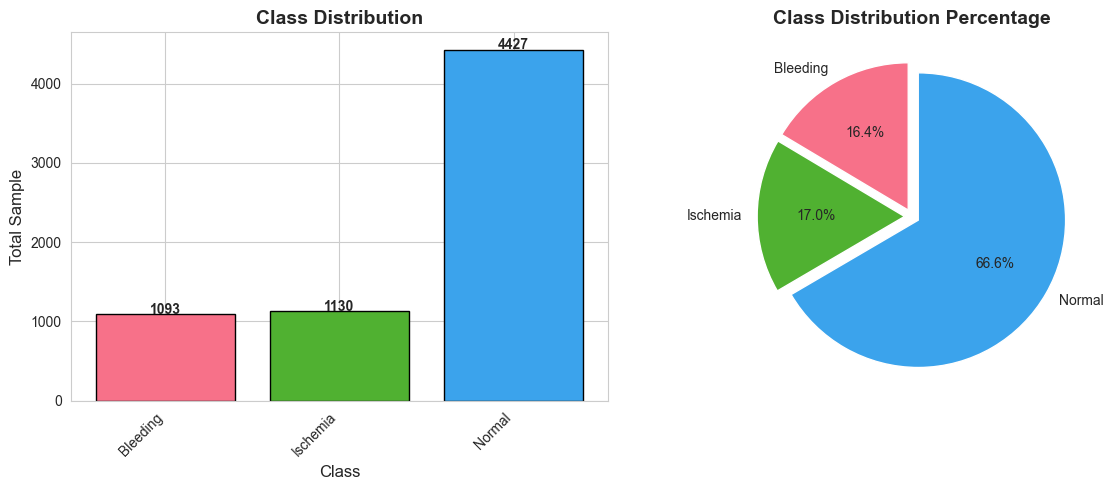

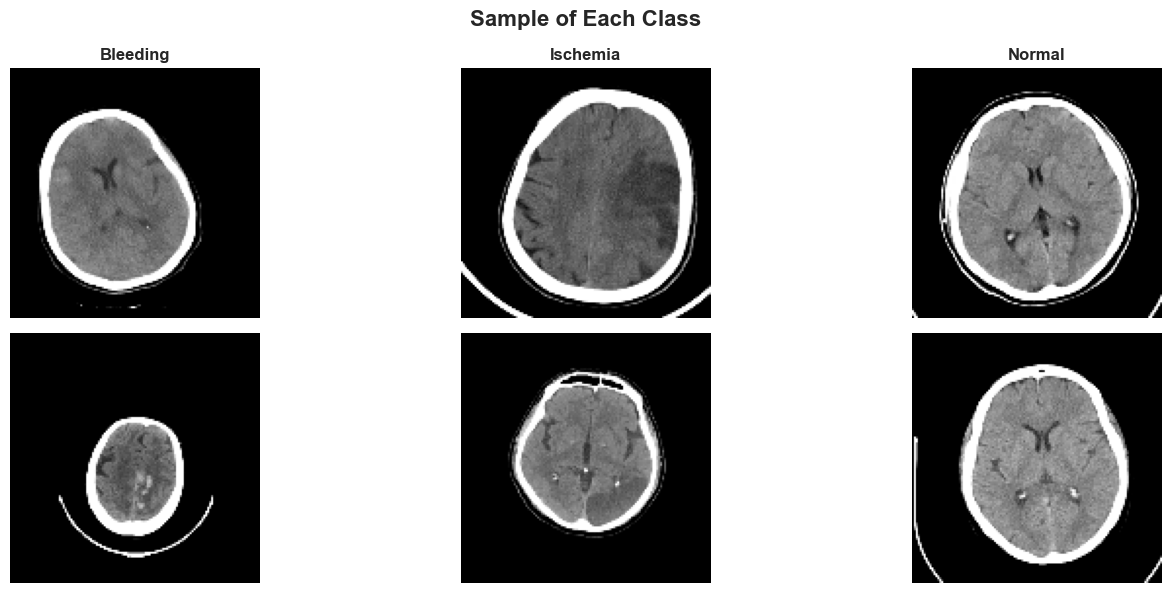


Pixel Intensity Statistic Each Class:

Bleeding:
  Mean Intensity: 47.46 ± 10.83
  Std Intensity: 77.63 ± 7.89

Ischemia:
  Mean Intensity: 43.03 ± 11.82
  Std Intensity: 73.66 ± 7.38

Normal:
  Mean Intensity: 49.73 ± 12.38
  Std Intensity: 80.94 ± 7.64


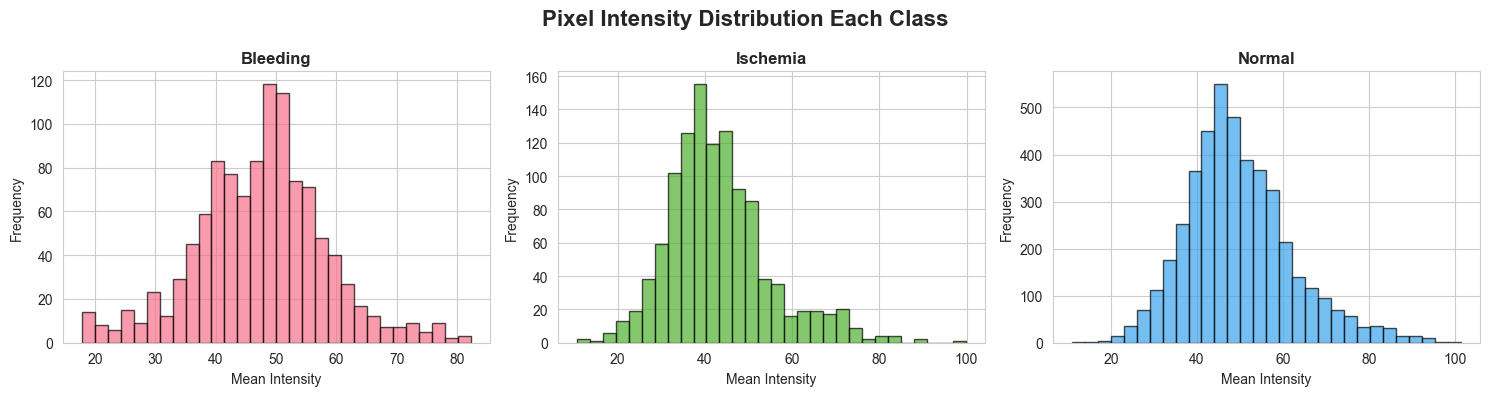

Total Sample: 6650
Image Size: (128, 128, 3)
Total Class: 3
CLass Name: Bleeding, Ischemia, Normal


In [62]:
def perform_eda(images, labels, class_names):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    unique, counts = np.unique(labels, return_counts=True)
    colors = sns.color_palette("husl", len(class_names))
    plt.bar(unique, counts, color=colors, edgecolor='black')
    plt.title('Class Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Total Sample', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    for i, (cls, cnt) in enumerate(zip(unique, counts)):
        plt.text(i, cnt + 5, str(cnt), ha='center', fontweight='bold')
    
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=unique, autopct='%1.1f%%', colors=colors, 
            startangle=90, explode=[0.05]*len(unique))
    plt.title('Class Distribution Percentage', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    n_classes = len(class_names)
    fig, axes = plt.subplots(2, n_classes, figsize=(15, 6))
    
    for idx, class_name in enumerate(class_names):
        class_indices = np.where(labels == class_name)[0]
        sample_indices = np.random.choice(class_indices, 2, replace=False)
        
        for row, sample_idx in enumerate(sample_indices):
            img = images[sample_idx]
            ax = axes[row, idx] if n_classes > 1 else axes[row]
            
            if len(img.shape) == 3:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                ax.imshow(img, cmap='gray')
            
            if row == 0:
                ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')
            ax.axis('off')
    
    plt.suptitle('Sample of Each Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nPixel Intensity Statistic Each Class:")
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))
    
    for idx, class_name in enumerate(class_names):
        class_indices = np.where(labels == class_name)[0]
        class_images = images[class_indices]
        
        mean_intensities = []
        std_intensities = []
        
        for img in class_images:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
            mean_intensities.append(np.mean(gray))
            std_intensities.append(np.std(gray))
        
        print(f"\n{class_name}:")
        print(f"  Mean Intensity: {np.mean(mean_intensities):.2f} ± {np.std(mean_intensities):.2f}")
        print(f"  Std Intensity: {np.mean(std_intensities):.2f} ± {np.std(std_intensities):.2f}")
        
        ax = axes[idx] if len(class_names) > 1 else axes
        ax.hist(mean_intensities, bins=30, color=colors[idx], alpha=0.7, edgecolor='black')
        ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Mean Intensity')
        ax.set_ylabel('Frequency')
    
    plt.suptitle('Pixel Intensity Distribution Each Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Total Sample: {len(images)}")
    print(f"Image Size: {images[0].shape}")
    print(f"Total Class: {len(class_names)}")
    print(f"CLass Name: {', '.join(class_names)}")

perform_eda(images, labels, class_names)

In [63]:
def preprocess_images(images):
    images_gray = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images_gray.append(gray)
    
    print(f"Converted {len(images_gray)} images to grayscale")
    print(f"Image shape: {images_gray[0].shape}")
    
    return np.array(images_gray)

In [64]:
images_gray = preprocess_images(images)

Converted 6650 images to grayscale
Image shape: (128, 128)


In [65]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        radius = 2           
        n_points = 8 * radius  
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3),
                            range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_features.append(hist)
    return np.array(lbp_features)

def extract_color_histogram(images_color):
    hist_features = []
    for img in images_color:
        hist = []
        for i in range(3):
            channel_hist = cv2.calcHist([img], [i], None, [32], [0, 256])
            channel_hist = channel_hist.flatten()
            hist.extend(channel_hist)
        hist_features.append(hist)
    return np.array(hist_features)

In [66]:
def extract_all_features(images_color, images_gray):
    print("Extracting HOG features...")
    hog_features = extract_hog_features(images_gray)
    print(f"  → HOG shape: {hog_features.shape}")
    
    print("Extracting LBP features...")
    lbp_features = extract_lbp_features(images_gray)
    print(f"  → LBP shape: {lbp_features.shape}")
    
    print("Extracting Color Histogram features...")
    hist_features = extract_color_histogram(images_color)
    print(f"  → Color Hist shape: {hist_features.shape}")
    
    combined_features = np.hstack([hog_features, lbp_features, hist_features])
    print(f"\nCombined features shape: {combined_features.shape}")
    
    return combined_features, hog_features, lbp_features, hist_features

In [67]:
combined_features, hog_feat, lbp_feat, hist_feat = extract_all_features(images, images_gray)

Extracting HOG features...
  → HOG shape: (6650, 8100)
Extracting LBP features...
  → LBP shape: (6650, 18)
Extracting Color Histogram features...
  → Color Hist shape: (6650, 96)

Combined features shape: (6650, 8214)


In [68]:
def normalize_features(hog_feat, lbp_feat, hist_feat):
    scaler_hog = StandardScaler()
    hog_normalized = scaler_hog.fit_transform(hog_feat)
    
    scaler_lbp = StandardScaler()
    lbp_normalized = scaler_lbp.fit_transform(lbp_feat)
    
    scaler_hist = MinMaxScaler()
    hist_normalized = scaler_hist.fit_transform(hist_feat)
    
    normalized_features = np.hstack([hog_normalized, lbp_normalized, hist_normalized])
    
    print(f"HOG normalized: {hog_normalized.shape}")
    print(f"LBP normalized: {lbp_normalized.shape}")
    print(f"Histogram normalized: {hist_normalized.shape}")
    print(f"Combined normalized features: {normalized_features.shape}")

    scalers = {
        'hog': scaler_hog,
        'lbp': scaler_lbp,
        'hist': scaler_hist
    }
    
    return normalized_features, scalers

In [69]:
normalized_features, scalers = normalize_features(hog_feat, lbp_feat, hist_feat)

HOG normalized: (6650, 8100)
LBP normalized: (6650, 18)
Histogram normalized: (6650, 96)
Combined normalized features: (6650, 8214)


In [70]:
def apply_pca(features, n_components=200):
    n_components = min(n_components, features.shape[1], features.shape[0])
    
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    
    explained_variance = np.sum(pca.explained_variance_ratio_)
    
    print(f"Original features: {features.shape}")
    print(f"PCA features: {features_pca.shape}")
    print(f"Explained variance: {explained_variance:.4f} ({explained_variance*100:.2f}%)")
    
    return features_pca, pca

In [71]:
use_pca = True
n_components = 200

if use_pca:
    hog_norm_only = normalized_features[:, :8100]  # HOG features
    lbp_norm_only = normalized_features[:, 8100:8118]  # LBP features 
    hist_norm_only = normalized_features[:, 8118:]  # Hist features
    
    pca = PCA(n_components=n_components)
    hog_pca = pca.fit_transform(hog_norm_only)
    
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"HOG before PCA: {hog_norm_only.shape}")
    print(f"HOG after PCA: {hog_pca.shape}")
    print(f"Explained variance: {explained_variance:.4f} ({explained_variance*100:.2f}%)")
    
    final_features = np.hstack([hog_pca, lbp_norm_only, hist_norm_only])
    print(f"Final features shape: {final_features.shape}")
else:
    final_features = normalized_features
    pca = None
    print("\n[INFO] Skipping PCA - Using normalized features directly")

HOG before PCA: (6650, 8100)
HOG after PCA: (6650, 200)
Explained variance: 0.5852 (58.52%)
Final features shape: (6650, 314)


In [72]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Original labels: {label_encoder.classes_}")
print(f"Encoded values: {np.unique(labels_encoded)}")

Original labels: ['Bleeding' 'Ischemia' 'Normal']
Encoded values: [0 1 2]


In [73]:
def split_data(features, labels, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Split ratio: {(1-test_size)*100:.0f}% / {test_size*100:.0f}%")
    
    return X_train, X_test, y_train, y_test

In [74]:
X_train, X_test, y_train, y_test = split_data(final_features, labels_encoded)

Training set: 5320 samples
Testing set: 1330 samples
Split ratio: 80% / 20%


In [75]:
def train_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    knn = KNeighborsClassifier()
    
    print("Running Grid Search with 5-fold Cross Validation...")
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', 
                            n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"\nBest Parameters:")
    for param, value in best_params.items():
        print(f"  - {param}: {value}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    
    return best_model, best_params

In [76]:
knn_model, best_params = train_knn(X_train, y_train)

Running Grid Search with 5-fold Cross Validation...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters:
  - metric: manhattan
  - n_neighbors: 3
  - weights: distance
Best CV Score: 0.9301


In [77]:
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1-Score : {f1:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_test, y_pred)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'y_true': y_test,
        'y_pred': y_pred
    }
    
    return metrics

In [78]:
metrics = evaluate_model(knn_model, X_test, y_test, class_names)


Overall Metrics:
  Accuracy : 0.9586
  Precision: 0.9584
  Recall   : 0.9586
  F1-Score : 0.9583
Classification Report:
              precision    recall  f1-score   support

    Bleeding       0.95      0.88      0.91       219
    Ischemia       0.95      0.95      0.95       226
      Normal       0.96      0.98      0.97       885

    accuracy                           0.96      1330
   macro avg       0.95      0.94      0.94      1330
weighted avg       0.96      0.96      0.96      1330



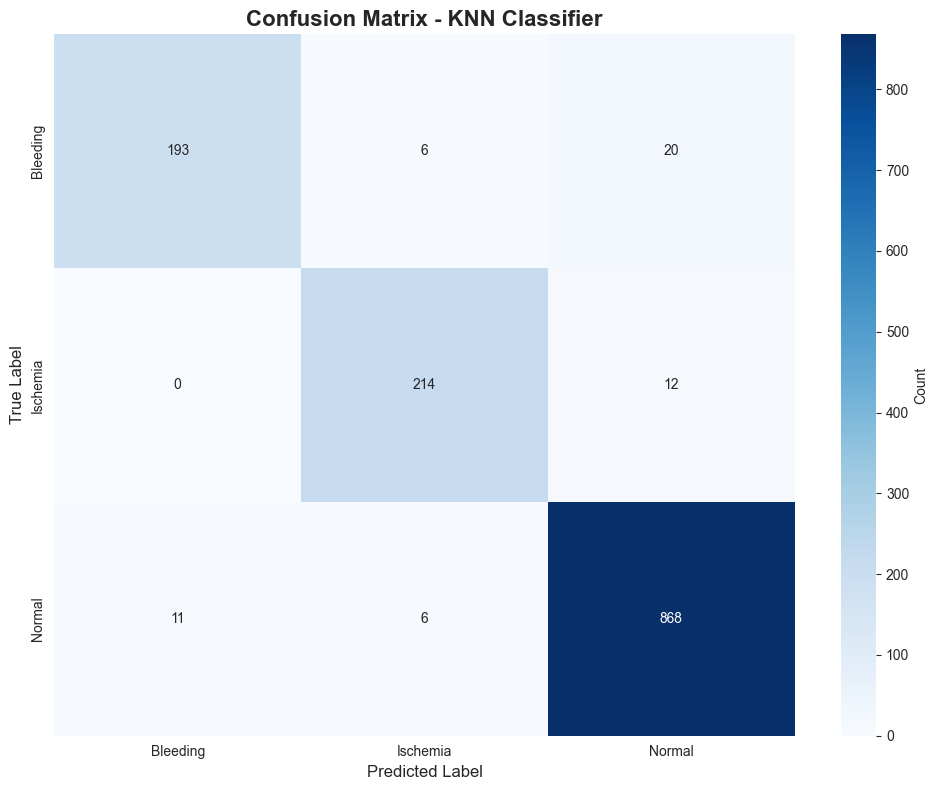

In [79]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - KNN Classifier', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(metrics['confusion_matrix'], class_names)


Matrix Each Class:
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bleeding             0.0000       0.0000       0.0000       0         
Ischemia             0.0000       0.0000       0.0000       0         
Normal               0.0000       0.0000       0.0000       0         


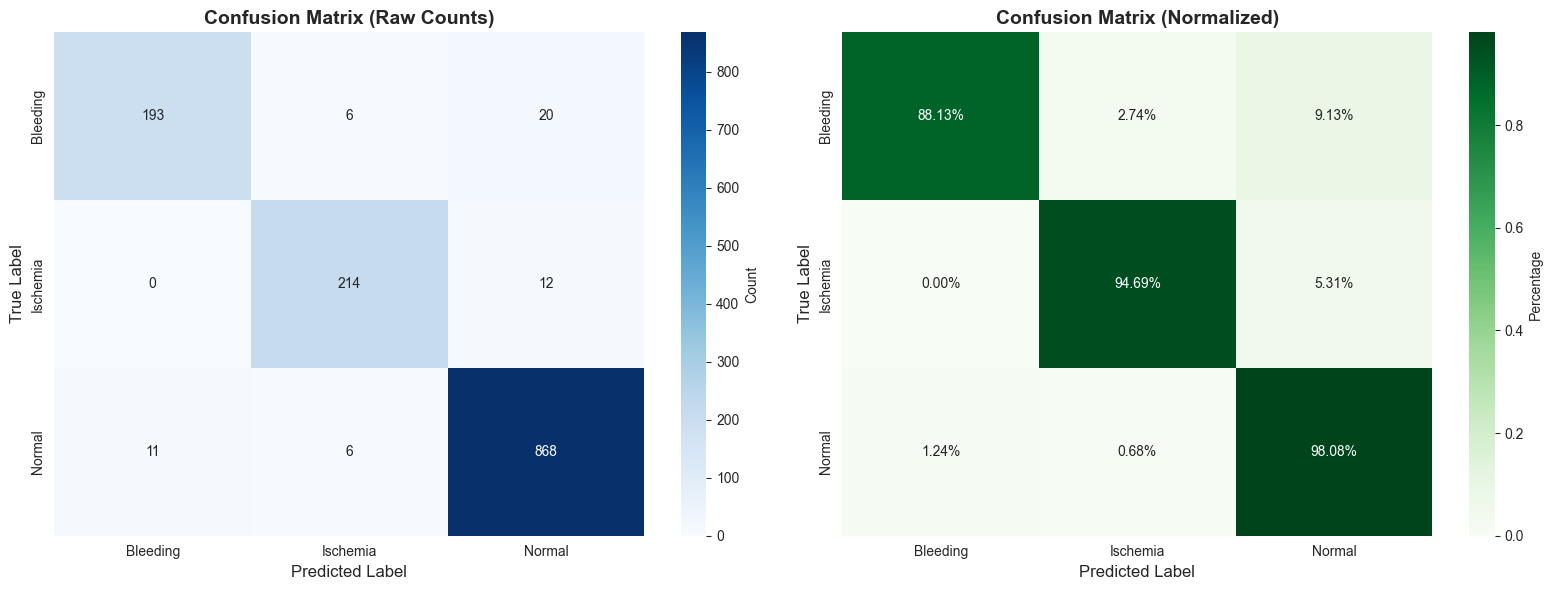

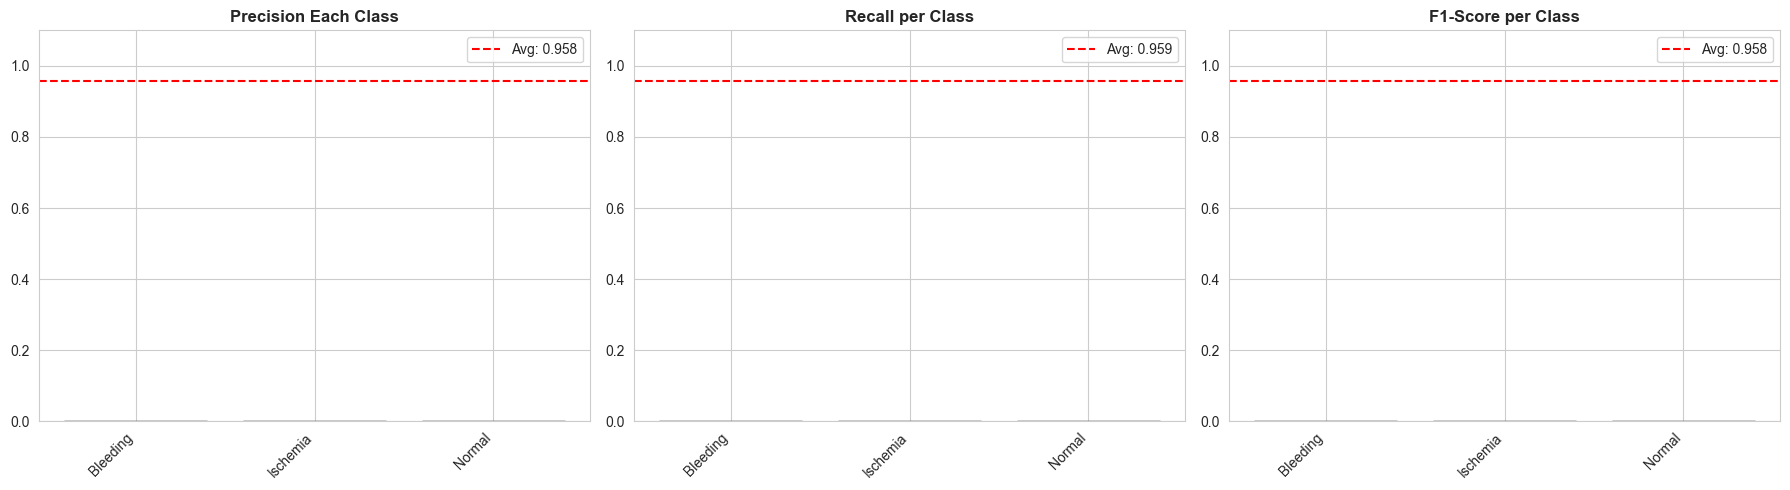

ERROR ANALYSIS:
Total of Wrong Prediction: 55 dari 1330 (4.14%)
Total of Right Prediction: 1275 (95.86%)

Most Common Classification Mistakes:
  0 → 2: 20 time (36.4%)
  1 → 2: 12 time (21.8%)
  2 → 0: 11 time (20.0%)
  0 → 1: 6 time (10.9%)
  2 → 1: 6 time (10.9%)


In [80]:
def additional_evaluation_metrics(metrics, class_names):
    cm = metrics['confusion_matrix']
    y_true = metrics['y_true']
    y_pred = metrics['y_pred']
    
    print("\nMatrix Each Class:")
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 70)
    
    for idx, class_name in enumerate(class_names):
        class_mask = (y_true == class_name)
        
        tp = np.sum((y_true == class_name) & (y_pred == class_name))
        fp = np.sum((y_true != class_name) & (y_pred == class_name))
        fn = np.sum((y_true == class_name) & (y_pred != class_name))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = np.sum(class_mask)
        
        print(f"{class_name:<20} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {support:<10}")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Percentage'})
    axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for class_name in class_names:
        tp = np.sum((y_true == class_name) & (y_pred == class_name))
        fp = np.sum((y_true != class_name) & (y_pred == class_name))
        fn = np.sum((y_true == class_name) & (y_pred != class_name))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    x_pos = np.arange(len(class_names))
    
    axes[0].bar(x_pos, precisions, color='skyblue', edgecolor='black')
    axes[0].set_title('Precision Each Class', fontsize=12, fontweight='bold')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0].set_ylim([0, 1.1])
    axes[0].axhline(y=metrics['precision'], color='r', linestyle='--', label=f"Avg: {metrics['precision']:.3f}")
    axes[0].legend()
    
    axes[1].bar(x_pos, recalls, color='lightcoral', edgecolor='black')
    axes[1].set_title('Recall per Class', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1].set_ylim([0, 1.1])
    axes[1].axhline(y=metrics['recall'], color='r', linestyle='--', label=f"Avg: {metrics['recall']:.3f}")
    axes[1].legend()
    
    axes[2].bar(x_pos, f1_scores, color='lightgreen', edgecolor='black')
    axes[2].set_title('F1-Score per Class', fontsize=12, fontweight='bold')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(class_names, rotation=45, ha='right')
    axes[2].set_ylim([0, 1.1])
    axes[2].axhline(y=metrics['f1_score'], color='r', linestyle='--', label=f"Avg: {metrics['f1_score']:.3f}")
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("ERROR ANALYSIS:")
    
    misclassified = y_true != y_pred
    n_misclassified = np.sum(misclassified)
    
    print(f"Total of Wrong Prediction: {n_misclassified} dari {len(y_true)} ({n_misclassified/len(y_true)*100:.2f}%)")
    print(f"Total of Right Prediction: {len(y_true) - n_misclassified} ({(1 - n_misclassified/len(y_true))*100:.2f}%)")
    
    print("\nMost Common Classification Mistakes:")
    error_pairs = {}
    for true, pred in zip(y_true[misclassified], y_pred[misclassified]):
        pair = (true, pred)
        error_pairs[pair] = error_pairs.get(pair, 0) + 1
    
    sorted_errors = sorted(error_pairs.items(), key=lambda x: x[1], reverse=True)
    for (true_class, pred_class), count in sorted_errors[:5]:
        print(f"  {true_class} → {pred_class}: {count} time ({count/n_misclassified*100:.1f}%)")
    
additional_evaluation_metrics(metrics, class_names)

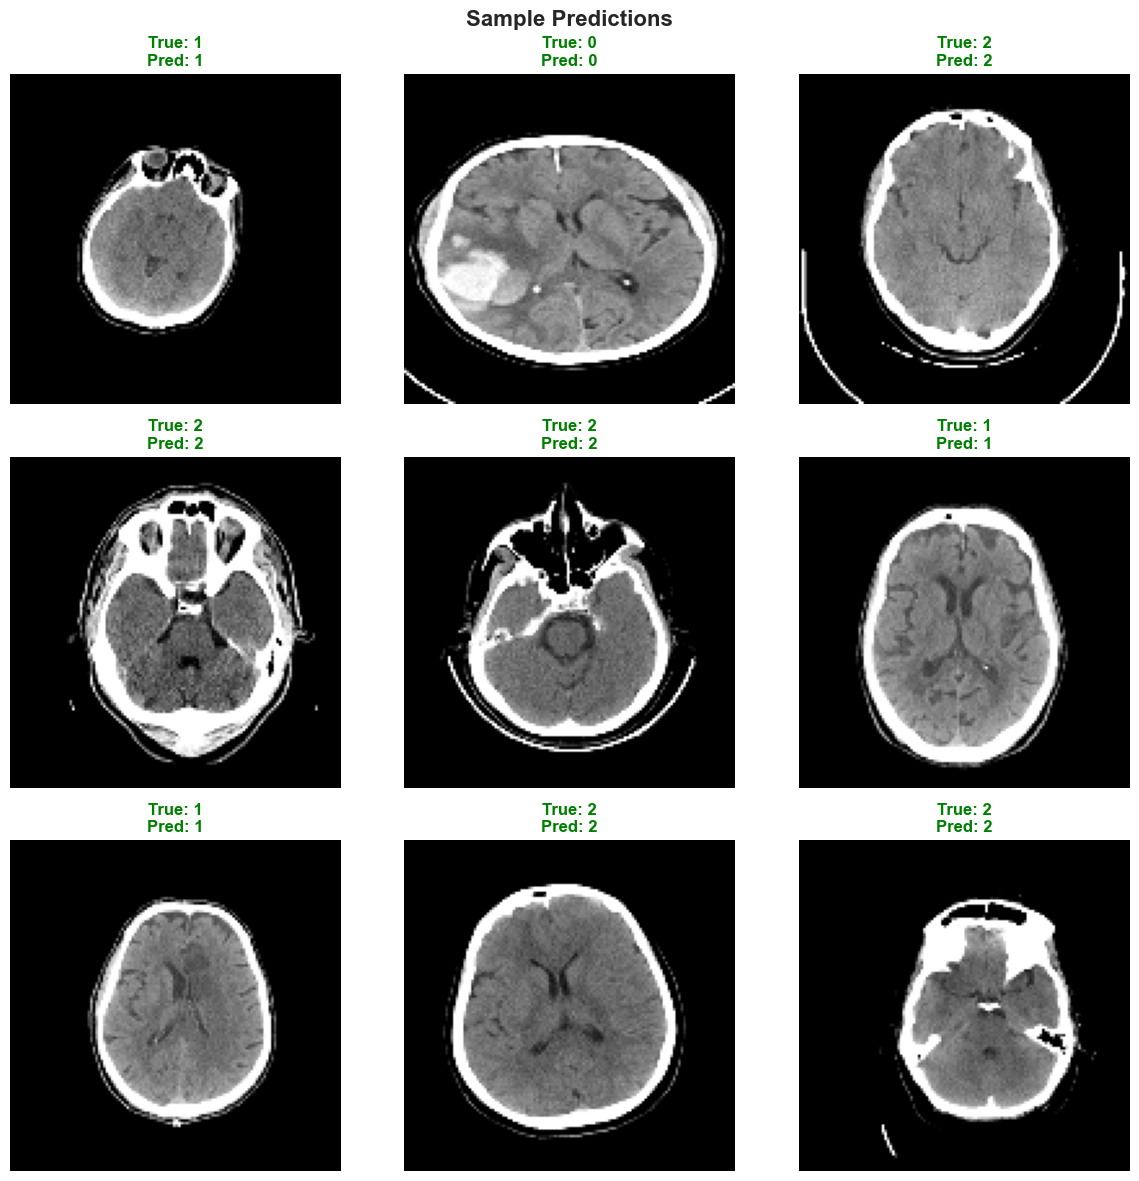

In [81]:
def plot_sample_predictions(images, y_true, y_pred, class_names, n_samples=9):
    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    
    for idx, ax in enumerate(axes):
        if idx < len(indices):
            i = indices[idx]
            img = images[i]
            true_label = y_true[i]
            pred_label = y_pred[i]
            
            if len(img.shape) == 3:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                ax.imshow(img, cmap='gray')
            
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'True: {true_label}\nPred: {pred_label}', 
                        color=color, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.suptitle('Sample Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

_, X_test_full, _, y_test_full = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

plot_sample_predictions(X_test_full, metrics['y_true'], metrics['y_pred'], class_names)

In [82]:
print(f"Final Model: K-Nearest Neighbors (KNN)")
print(f"Best Parameters: {best_params}")
print(f"Test Accuracy: {metrics['accuracy']:.4f}")
print(f"Test F1-Score: {metrics['f1_score']:.4f}")

Final Model: K-Nearest Neighbors (KNN)
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Test Accuracy: 0.9586
Test F1-Score: 0.9583


In [83]:
results = {
    'model': knn_model,
    'scalers': scalers,
    'pca': pca if use_pca else None,
    'metrics': metrics,
    'class_names': class_names,
    'best_params': best_params
}

In [84]:
all_features = np.hstack([hog_feat, lbp_feat, hist_feat])

df_features = pd.DataFrame(all_features)
df_features['label'] = labels

output_csv_path = "extracted_features.csv"
df_features.to_csv(output_csv_path, index=False)

In [ ]:
import pickle

with open('scaler_hog.pkl', 'wb') as f:
    pickle.dump(scalers['hog'], f)

with open('scaler_lbp.pkl', 'wb') as f:
    pickle.dump(scalers['lbp'], f)

with open('scaler_hist.pkl', 'wb') as f:
    pickle.dump(scalers['hist'], f)

with open('scalers_all.pkl', 'wb') as f:
    pickle.dump(scalers, f)

if pca is not None:
    with open('pca.pkl', 'wb') as f:
        pickle.dump(pca, f)

with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)

In [87]:
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(labels_encoded, f)